In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from networkx.algorithms import bipartite

%matplotlib inline

In [28]:
url = 'https://github.com/kmlee419/patent_analysis/raw/main/tesla_ipc_200.csv'
df = pd.read_csv(url)

HTTPError: HTTP Error 404: Not Found

### 총 특허 수

In [6]:
len(df['patent'].drop_duplicates())

200

### 총 코드 수

In [7]:
len(df['code'].drop_duplicates())

934

### 대상년도

In [8]:
print(min(df['date']), max(df['date']))

2006-02-13 2019-10-22


### 연도별 총 특허 수 

In [9]:
df2 = df[['patent', 'year']].drop_duplicates()
group_year = df2.groupby('year')['patent'].count()
group_year = group_year.reset_index()

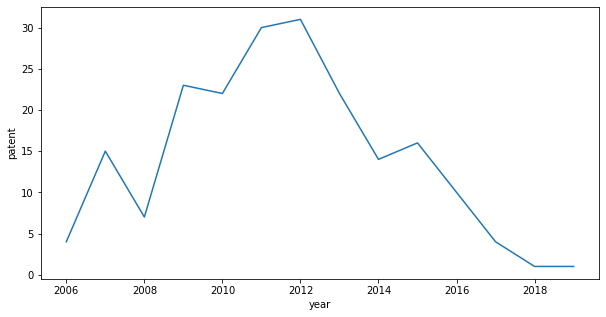

In [10]:
plt.figure(figsize=(10, 5))
sns.lineplot(data=group_year, x='year', y='patent')
plt.show()

### 가장 많이 사용된 코드 top N list

In [11]:
code_count = df['code'].value_counts().reset_index()

In [13]:
code_count.head(10) # 숫자를 바꾸면 top N 조절 가능

,index,code
0,Y02E60/10,76
1,Y02T10/70,73
2,Y02T10/7072,35
3,Y02T90/14,31
4,H01M10/613,27
5,H01M10/625,27
6,Y02T90/12,24
7,B60L58/26,23
8,B60L2240/545,21
9,H01M50/20,20


### 가장 많이 사용된 코드 top N list (연도별)

In [14]:
year = 2012 # 연도 바꾸기 가능

df_year = df[df['year']==year]
code_count = df_year['code'].value_counts().reset_index()
code_count.head(20) # 순위 개수 바꾸기 가능

,index,code
0,Y02T10/70,11
1,Y02E60/10,8
2,Y02T90/14,6
3,Y02T10/7072,6
4,H01M50/20,5
5,H01M10/653,4
6,Y02T90/12,3
7,B60L3/0046,3
8,B60L2240/545,3
9,H01M50/24,3


### 코드별 연도변화

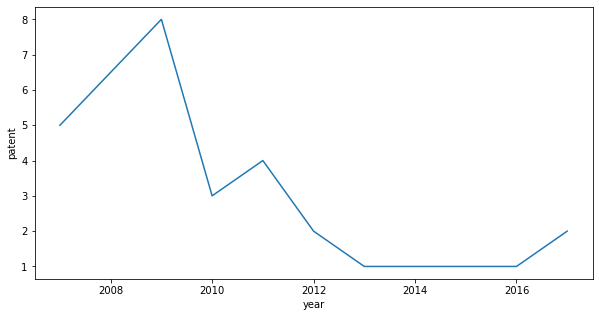

In [15]:
code = 'H01M10/613' # 코드 바꾸기 가능

df_code = df[df['code']==code]
df_code2 = df_code[['patent', 'year']].drop_duplicates()
code_year = df_code2.groupby('year')['patent'].count()
code_year = code_year.reset_index()

plt.figure(figsize=(10, 5))
sns.lineplot(data=code_year, x='year', y='patent')
plt.show()

### 코드별 전년대비 변화량 

In [16]:
years = list(df['year'].drop_duplicates().sort_values())

diff = pd.DataFrame(columns = ['index', 'diff', 'by_year'])
for i in range(0, len(years)-1):
    year1 = years[i]
    year2 = years[i+1]
    
    df_year1 = df[df['year']==year1]
    code_count1 = df_year1['code'].value_counts().reset_index()
    df_year2 = df[df['year']==year2]
    code_count2 = df_year2['code'].value_counts().reset_index()
    
    merge = pd.merge(code_count1, code_count2, on='index', how='outer')
    merge = merge.fillna(0)
    merge['diff'] = merge['code_y'] - merge['code_x']
    merge['by_year'] = str(year1) + "-" + str(year2)
    
    diff = pd.concat([diff, merge[['index', 'diff', 'by_year']]])

In [17]:
diff.sort_values(by='diff', ascending=False).head(10) 

,index,diff,by_year
7,Y02E60/10,11.0,2008-2009
0,Y02T10/70,10.0,2006-2007
50,H01M10/613,8.0,2008-2009
17,B60L58/26,7.0,2006-2007
2,Y02E60/10,6.0,2006-2007
19,Y02T90/16,6.0,2006-2007
18,B60L2240/545,6.0,2006-2007
51,H01M10/643,5.0,2008-2009
20,H01M10/613,5.0,2006-2007
2,Y02T10/70,5.0,2010-2011


In [18]:
diff.sort_values(by='diff', ascending=True).head(10)

,index,diff,by_year
0,Y02T10/70,-9.0,2007-2008
2,B60L58/26,-7.0,2007-2008
0,Y02T10/70,-7.0,2012-2013
1,Y02E60/10,-6.0,2007-2008
4,B60K2370/1438,-5.0,2010-2011
3,B60K2370/143,-5.0,2010-2011
1,B60K35/00,-5.0,2010-2011
2,Y02T90/14,-5.0,2012-2013
5,H01M10/613,-5.0,2007-2008
1,H01M10/613,-5.0,2009-2010


### 전체 네트워크 분석

In [20]:
def network_generation(df):
    U_nodes = list(df['code'].drop_duplicates())
    V_nodes = list(df['patent'].drop_duplicates())
    edgelist = list(zip(df['code'], df['patent']))

    B_df = nx.Graph()
    B_df.add_nodes_from(U_nodes, bipartite=0)
    B_df.add_nodes_from(V_nodes, bipartite=1)

    B_df.add_edges_from(edgelist)
    G = bipartite.collaboration_weighted_projected_graph(B_df, U_nodes)

    return G

In [21]:
G = network_generation(df)

In [22]:
degree = nx.degree_centrality(G)
betweenness = nx.betweenness_centrality(G)
closeness = nx.closeness_centrality(G)
eigenvector = nx.eigenvector_centrality(G)

nx.set_node_attributes(G, degree, 'degree')
nx.set_node_attributes(G, betweenness, 'betweenness')
nx.set_node_attributes(G, closeness, 'closeness')
nx.set_node_attributes(G, eigenvector, 'eigenvector')

In [24]:
df_g = pd.DataFrame.from_dict(dict(G.nodes(data=True)), orient='index')
df_g['dbratio'] = df_g['betweenness'] / df_g['degree']

In [25]:
# degree 대비 betweenness가 높은 코드 순서로 출력
df_g.sort_values(by='dbratio', ascending=False).head(10)

,bipartite,degree,betweenness,closeness,eigenvector,dbratio
G01C21/3697,0,0.013934,0.110732,0.301457,2.421677e-03,7.947177
G06F3/0488,0,0.015005,0.025440,0.229687,2.972715e-05,1.695372
E05Y2400/86,0,0.025723,0.038153,0.153488,3.957551e-08,1.483190
B60K35/00,0,0.031083,0.043988,0.185412,2.520021e-06,1.415200
Y02E60/00,0,0.103966,0.071365,0.379212,3.408902e-02,0.686430
B62D25/025,0,0.039657,0.024124,0.319356,9.285667e-03,0.608315
H02M7/003,0,0.012862,0.007102,0.313462,1.998274e-03,0.552217
E05Y2900/531,0,0.023580,0.010626,0.130309,6.874999e-10,0.450644
B62D25/082,0,0.016077,0.007102,0.313767,6.944194e-03,0.441774
Y02T10/7258,0,0.082529,0.035280,0.373290,8.256942e-02,0.427482


### 링크별 전년대비 변화량

In [26]:
years = list(df['year'].drop_duplicates().sort_values())

diff = pd.DataFrame(columns = ['source', 'target', 'diff', 'by_year'])
for i in range(0, len(years)-1):
    year1 = years[i]
    year2 = years[i+1]
    
    df_year1 = df[df['year']==year1]    
    df_year2 = df[df['year']==year2]

    G1 = network_generation(df_year1)
    G2 = network_generation(df_year2)
    
    df_g1 = nx.to_pandas_edgelist(G1)
    df_g2 = nx.to_pandas_edgelist(G2)
    
    df_merge = pd.merge(df_g1, df_g2, on=['source', 'target'], how='outer')
    df_merge = df_merge.fillna(0)
    df_merge['diff'] = df_merge['weight_y'] - df_merge['weight_x']
    df_merge['by_year'] = str(year1) + "-" + str(year2)
    
    diff = pd.concat([diff, df_merge[['source', 'target', 'diff', 'by_year']]])

In [27]:
diff.sort_values(by='diff', ascending=False).head(20)

,source,target,diff,by_year
550,H01M10/613,Y02E60/10,1.723214,2008-2009
900,H02J7/007194,H02J7/04,1.055556,2008-2009
1796,B60G15/067,B60G2204/128,1.000000,2011-2012
1572,G01K3/005,G08B17/06,1.000000,2008-2009
4394,H02P21/0021,H02P21/141,1.000000,2014-2015
2891,F16H63/3425,Y10T74/19637,1.000000,2011-2012
4134,B62D29/008,F16F7/12,1.000000,2013-2014
4329,B60J7/022,B60J7/0435,1.000000,2014-2015
2467,H02K9/20,H02K9/197,1.000000,2012-2013
1732,H01M50/20,Y02E60/10,0.964286,2011-2012
